# User27: Benedetto & Collura

Advances in imaging equipment and automation have led to an overabundance of data on the functioning of the brain. Technologies today can sample brain activity from a large number of neurons in a large region while organisms are actively behaving. For example, by simultaneously recording the electrical activity of every neuron of the mouse brain over an extended period of time, the amount of data generated will create completely new paradigms for biology, that will require the development of tools to extract value from such unprecedented amount of information.

In this Notebook, we use PySpark and the [Thunder project](https://github.com/thunder-project/thunder), which is developed on top of PySpark, for processing large amounts of time series data in general, and neuroimaging data in particular. We will use these tools for the task of understanding some of the structure of Zebrafish brains, which is a typical (and simple) example used in Neuroimaging. Using Thunder, we will cluster different regions of the brain (representing groups of neurons) to discover patterns of activity as the zebrafish behaves over time.

**Note**: Please, use the documentation for the [Thunder API](http://docs.thunder-project.org/) to learn the details of function calls!


# Goals

The main goals of this notebook are:

1. Learn about Thunder and how to use it
2. Revisit the K-Means algorithm and the method for choosing K
3. Learn alternative approaches to improve the results


# Steps
1. In section 1, we go though some background concepts that are used in this notebook.
2. Next, in section 2, we will get familiar with Thunder, its methods and its data types, by working on some simple tasks.
3. Finally, in section 3, we will build a model to cluster the neurons of a zebrafish based on their behavior. In this step, we will learn about how to use K-Means when the value of K is unknown. Finally, some tricks to improve the results are introduced.

# 1. Background concepts

In this section, we cover the terminology and the concepts that constitute the domain knowledge for this notebook.

As it should be well-known, a `pixel` is a combination of "**pic**ture **el**ement": digital images can be modeled as simple 2-dimensional (2D) matrices of intensity values, and each element in the matrix is a pixel. In color images, a pixel contains values of red, green, and blue channels. In a grayscale image, the three channels have the same value, such that each pixel is reduced to be a single value.

A single 2D image is not nearly enough to express 3D objects, which use a **voxel**, representing a value of the 3D image on a regular grid in a three-dimensional space.  A possible technique to work on 3D images is to acquire multiple 2D images of different slices (or `planes`, or `layers`) of a 3D object, and stack them one on top of each other (a z-stack). This ultimately produces a 3D matrix of intensity values, where each value represents a `volume element` or `voxel`.

![](https://upload.wikimedia.org/wikipedia/commons/b/b4/Voxelgitter.png)
<div style="text-align:center;">This z-stack image has 4 layers. A point is a voxel. It can be determined by the layer's index and the position in that layer.</div>

In the context of the Thunder package, we use term `image` for `3D-image` or `stack image`. Thunder uses `Image` type to  represent 3D-image. Each `Image` object is a collection of either 2D images or 3D volumes. In practice, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via  numpy , with an identical API.

Stack-images can represent 3D objects, but it can be difficult to take the temporal relationship of the images into account. To do that, we need another data structure that shows the changes of voxels over time. In the Thunder package, the internal `Series` type can be used exactly for this purpose. Each `Series` is a 1D array such that each element is a value of the voxel at a timestamp.

The most common series data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

We now have sufficient material to start playing with Thunder !!!

# 2. Let's play

Well, wait a second before we play... Remember, we're going to use Spark to perform some of the computations related to this Notebook. Now, when you spin a Zoe Notebook application (this comment is valid for students at Eurecom), you'll gain access to an individual, small Spark cluster that is dedicated to your Notebook. This cluster has two worker machines, each with 6 cores. As such, a good idea to obtain smooth performance and a balanced load on the workers, is to ```repartition``` your data (i.e., the RDDs you use to represent images or time series).

In this Notebook we **expect** students to take care of repartitioning, and such care will be compensated by bonus points.

## 2.1. Play with Image objects

### a. Loading image data

Both `images` and `series` can be loaded from a variety of data types and locations. You need to specify whether data should be loaded in 'local' mode, which is backed by a numpy array, or in 'spark' mode, which is backed by an RDD by using the optional argument `engine`. The argument `engine` can be either `None` for local use or a SparkContext for` distributed use with Spark.

```python
import thunder as td

# load data from tif images
data = td.images.fromtif('/path/to/tifs')

# load data from numpy-arrays
data = td.series.fromarray(somearray)
data_distributed = ts.series.fromarray(somearray, engine=sc)
```

We can load some example image data by:

In [1]:
import thunder as td
import numpy as np

# load some example image data
image_data = td.images.fromexample('fish', engine=sc)

# print the number of images
print(image_data.count())

20


<div class="alert alert-warning">
We can notice immediately that we have only 20 images, that definitely isn't a big number. We'll have to take this into account while analyzing the performances of the model.
</div>

### b. Inspecting image data

Shape of the data: (20, 2, 76, 87)
Shape of the data of the first image: (2, 76, 87)
Data of the first image: [[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


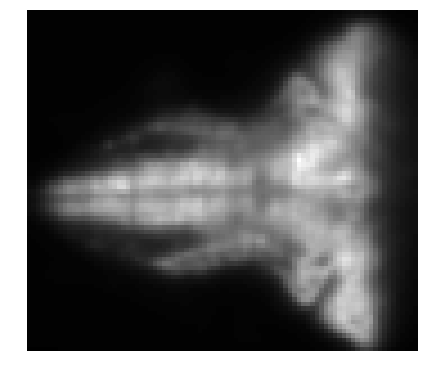

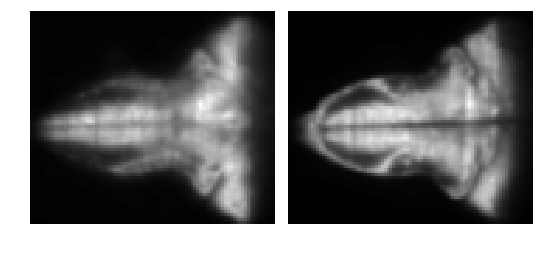

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile

print("Shape of the data:", image_data.shape)

first_image = image_data.first() # get the values of Image object
# or first_image = image_data[0] # get the Image object

print("Shape of the data of the first image:", first_image.shape)
print("Data of the first image:", first_image)


# draw the first layer of the first image
draw_image(first_image[0])

# draw all layers of the first image
draw_tile(first_image)

# we can use index slices to take images
samples = image_data[0:6]

From the result above, the shape of the loaded data is (20, 2, 76, 87). It means we have total 20  3D images objects. Each image has 2 layers, each layer has size 76x87. 

Note that, although  data  is not itself an array (it can be a kind of RDD), we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays. In these cases, the data will be automatically converted.

One of the advantages of working in Python is that we can easily visualize our data stored into Spark RDDs using the Matplotlib library. Function `draw_image` and `draw_tile` that take advantages of Matplotlib are examples.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 1

<div class="alert alert-info">  
a) Use the function `imgshow` from matplotlib to plot each layer of the first image in `image_data`.  

b) Discuss the choice of parameters you use for the method `imgshow`  

</div>

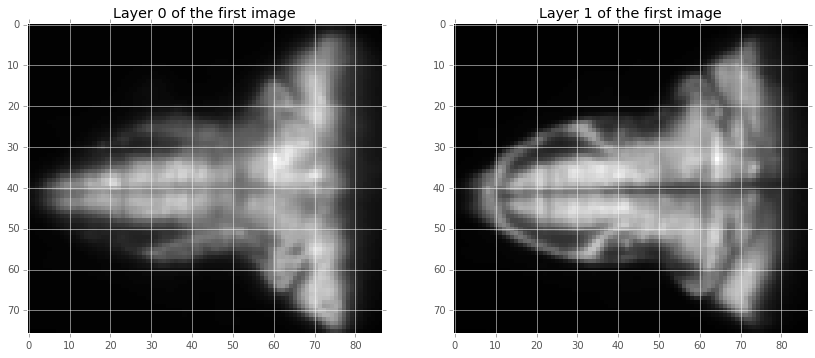

In [3]:
img = image_data.first() 
# or:
# img = image_data[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# show the first layer
ax1.imshow(img[0,:], interpolation='nearest', aspect='equal', cmap='gray')
ax1.set_title("Layer 0 of the first image")

# show the second layer
ax2.imshow(img[1,:], interpolation='nearest', aspect='equal', cmap='gray')
ax2.set_title("Layer 1 of the first image")
plt.show()

<div class="alert alert-warning">
There are several parameters we could play with:

<ul>

<li>**interpolation**: The acceptable values are ‘none’, ‘nearest’, ‘bilinear’, ‘bicubic’, ‘spline16’, ‘spline36’, ‘hanning’, ‘hamming’, ‘hermite’, ‘kaiser’, ‘quadric’, ‘catrom’, ‘gaussian’, ‘bessel’, ‘mitchell’, ‘sinc’, ‘lanczos’. We used nearest in the first example, but we could try something else... </li>

<li> **aspect**: It can be: ‘auto’, ‘equal’, a scalar, or None.
</li>

<li> **cmap**:it specifies the color map applied to the plot, in the first case we applied the black & white color map but we could also apply the standard one, that is coloured. </li>

<li> **norm**: a `norm` instance is used to scale a 2-D float X input to the (0, 1) range for input to the cmap. </li>
<li> **vmin**,**vmax**: used in conjunction with norm to normalize luminance data </li>
<li> **alpha**: The alpha blending value, between 0 (transparent) and 1 (opaque) </li>
<li> **origin**: Place the [0,0] index of the array in the upper left or lower left corner of the axes. </li>
<li> **extent**: The location, in data-coordinates, of the lower-left and upper-right corners. </li>
<li> **shape**</li>
<li> **filternorm** </li>
<li> **filterrad** </li>

</ul>

<br>

Obviously we cannot try all the possible combinations, but we could try a couple of key-ones to see how the plot changes.
<br>While analyzing the differences we will always print twice the layer 0 of the first image: on the left we will have the version with the "new" parameter, and on the right the one with the "old" parameter.

</div>

<div class="alert alert-info">  
The first try could be to change the colour scheme of the plot (**cmap**).
</div>

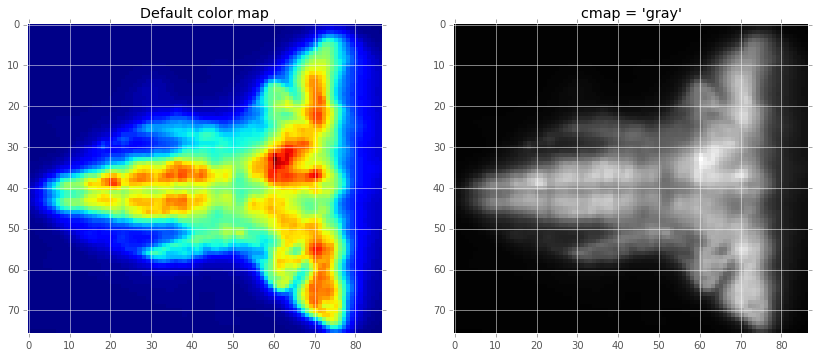

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax1.imshow(img[0,:], interpolation='nearest', aspect='equal')
ax1.set_title("Default color map")

ax2.imshow(img[0,:], interpolation='nearest', aspect='equal', cmap='gray')
ax2.set_title("cmap = 'gray'")
plt.show()

<div class="alert alert-warning">  
In our opinion, it is easier on the coloured one to spot the differences between the points.
</div>

<div class="alert alert-info">  
Now we could change the **aspect**</div>

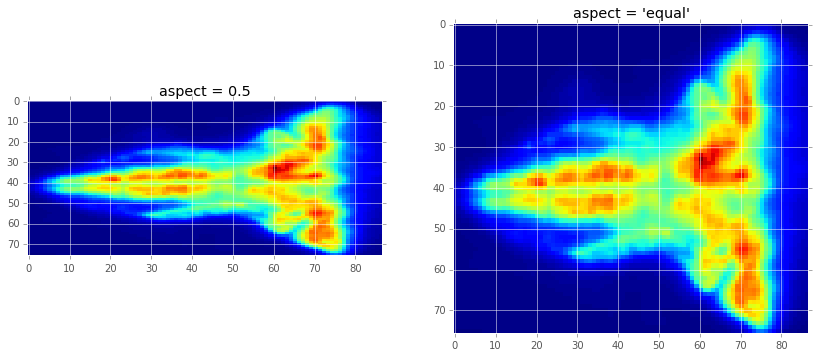

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax1.imshow(img[0,:], interpolation='nearest', aspect=.5)
ax1.set_title("aspect = 0.5")

ax2.imshow(img[0,:], interpolation='nearest', aspect='equal')
ax2.set_title("aspect = 'equal'")
plt.show()

<div class="alert alert-warning">  
**aspect** modifies the ratio between the size of the two axis, we think that the only choices that make sense (and we could use to work on) are equal, since it's a nice square, and auto, that changes the image aspect ration to match that of the axis.
</div>

<div class="alert alert-info">  
Finally, let's try with the **interpolation**
</div>

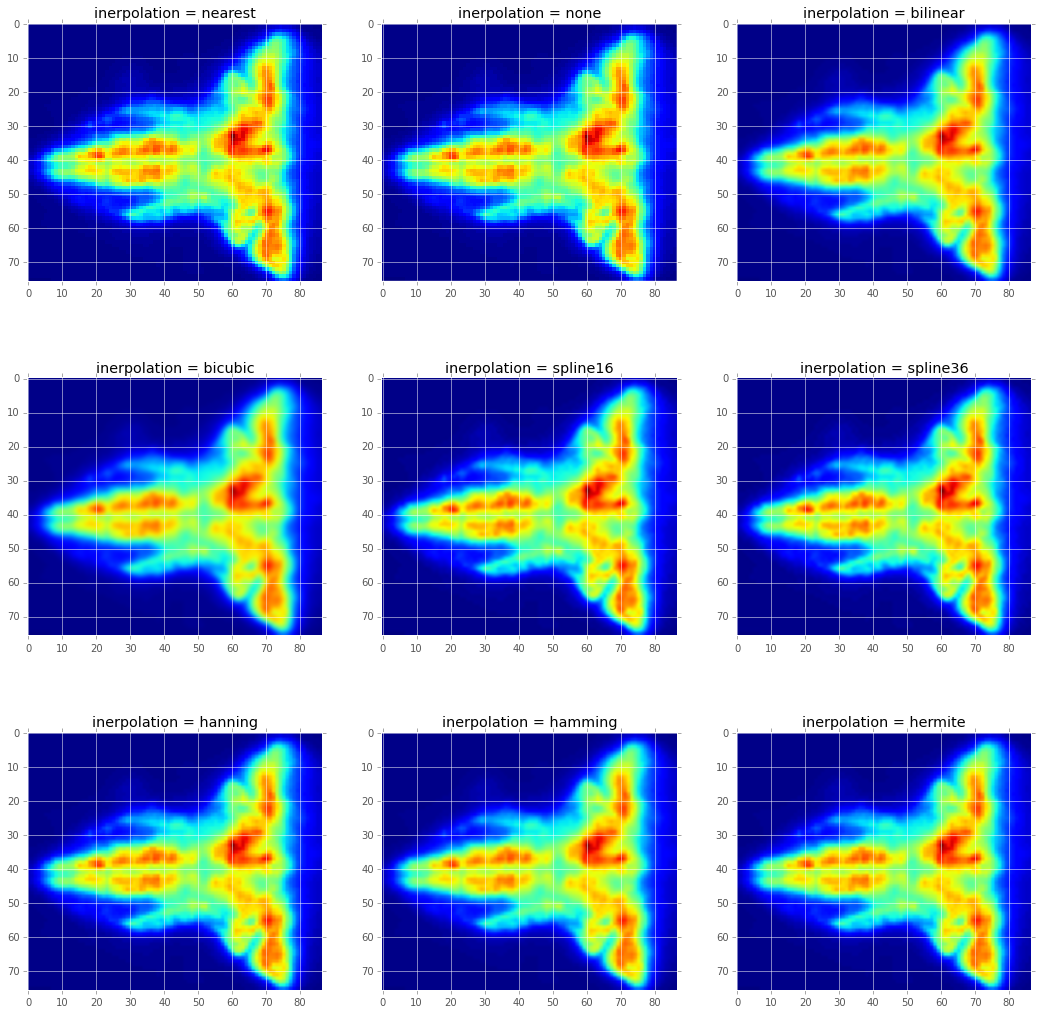

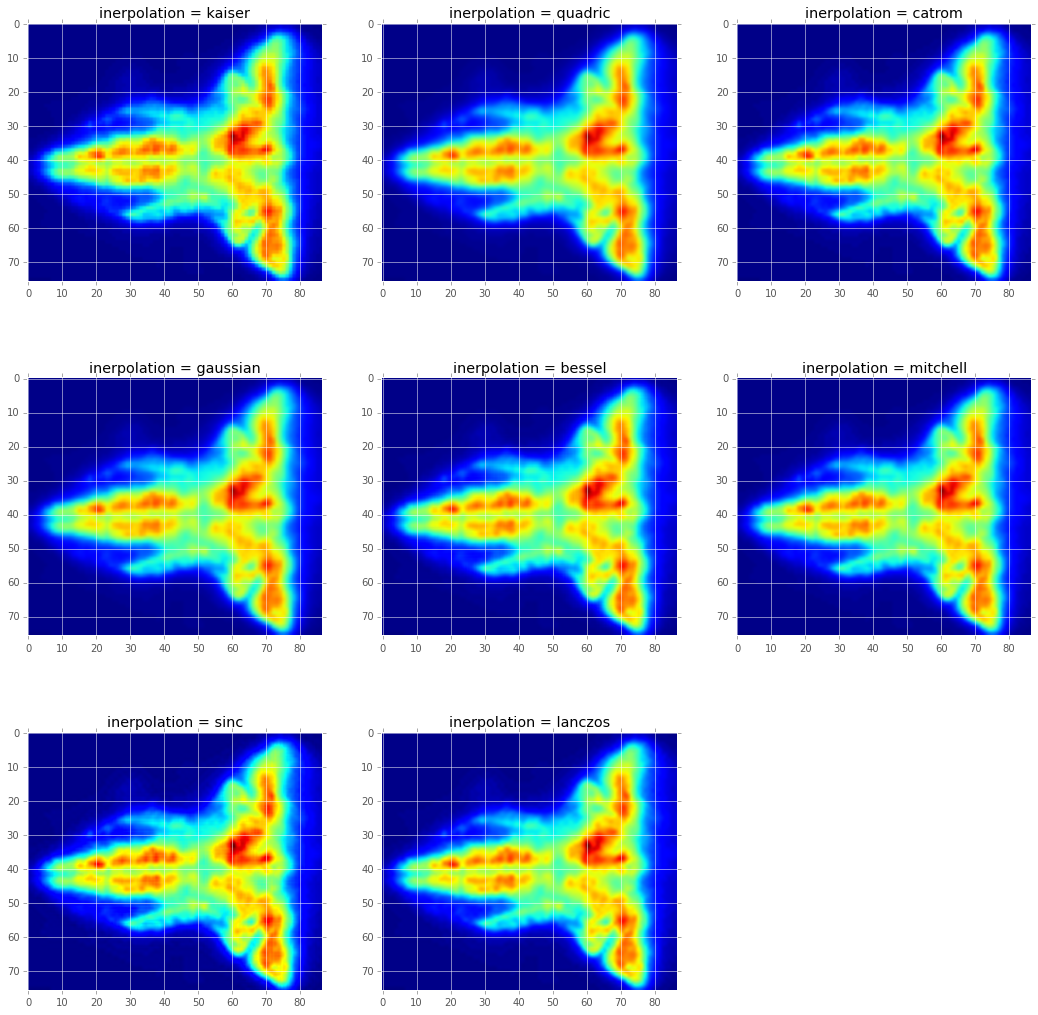

In [6]:
interpolations = ['nearest', 'none', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite']

fig = plt.figure(figsize=(18,18))

for i in range(len(interpolations)):
    ax = fig.add_subplot(330+(i+1))
    ax.imshow(img[0,:], interpolation=interpolations[i], aspect='equal')
    ax.set_title("inerpolation = " + interpolations[i])
    
plt.show()

interpolations = ['kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
fig = plt.figure(figsize=(18,18))

for i in range(len(interpolations)):
    ax = fig.add_subplot(330+(i+1))
    ax.imshow(img[0,:], interpolation=interpolations[i], aspect='equal')
    ax.set_title("inerpolation = " + interpolations[i])
    
plt.show()

<div class="alert alert-warning">  
Playing with the parameter interpolation we can see that the difference is in how smooth the image is. It is very easy to see the differences between, for instance, `nearest` interpolation and `bicubic`: in the first one we can see the pixels the image is made of while the second one is way smoother. In many of the other cases though it's not easy to see the differences, mainly because we decided to print the images in a small format, if we'd print bigger images, the differences would be more visible. 
</div>

Then, we can perform operations that aggregate information across images.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Calculate the standard deviation across all images you have in `image_data` (that is, our dataset). To clarify, let's focus on an individual layer (say the first layer of each image). For every `voxel`, compute the standard deviation of its values across different images for the same layer. Visualize the standard deviation you obtain, for example concerning a single layer (as before, say the first layer).

</div>

<div class="label label-success">HINT 1</div> to avoid wasting time and energy, make sure you lookup for methods that could help answer the question from the Thunder documentation.  

<div class="label label-success">HINT 2</div> We can also use function `draw_image(<data>)` to plot an image in a simple way instead of using many statements with matplotlib as before.

<div class="label label-danger">NOTE</div> Comment the image you obtain. What does it mean to display the standard deviation across all images in a single layer?

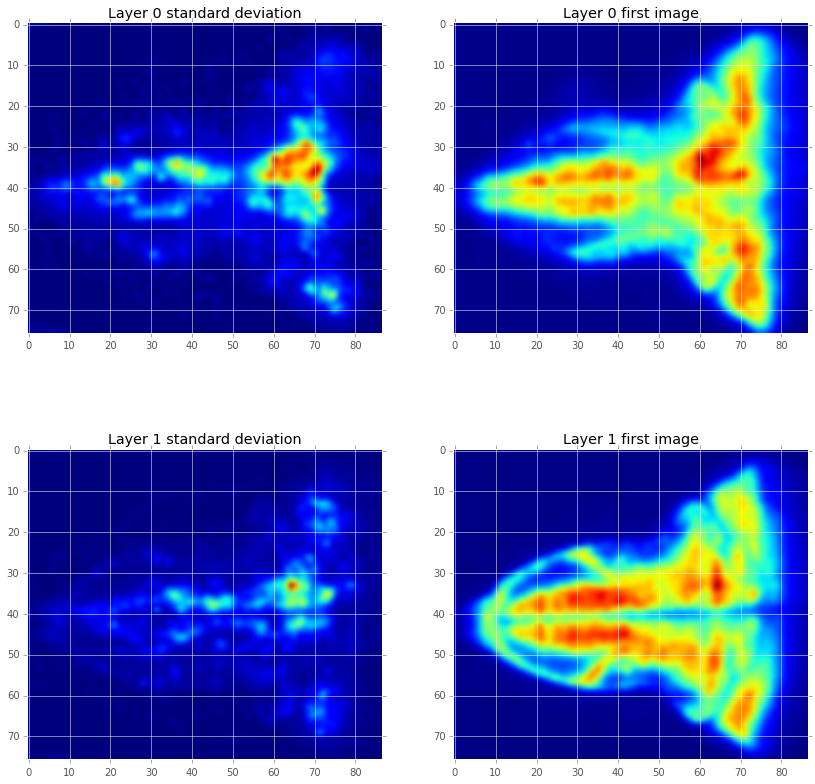

In [7]:
# calculate standard deviation of images
std_imgs = image_data.std()

fig = plt.figure(figsize=(14,14))

ax = fig.add_subplot(221)
ax.imshow(std_imgs.first()[0], interpolation='bicubic', aspect='equal')
ax.set_title("Layer 0 standard deviation")

ax = fig.add_subplot(222)
ax.imshow(image_data.first()[0], interpolation='bicubic', aspect='equal')
ax.set_title("Layer 0 first image")

ax = fig.add_subplot(223)
ax.imshow(std_imgs.first()[1], interpolation='bicubic', aspect='equal')
ax.set_title("Layer 1 standard deviation")

ax = fig.add_subplot(224)
ax.imshow(image_data.first()[1], interpolation='bicubic', aspect='equal')
ax.set_title("Layer 1 first image")

plt.show()

<div class="alert alert-warning">  
We decided to print on the left the standard deviation of both the layers and, for each layer, to print one of the images as well (on the right).
<br>
In the plot of the standard deviation, the red points are the areas of the brain whose usage changes the most, i.e. they are used intermittently. On the other hand, if we look at the images on the right, the red areas are those that are used the most (in that given moment, obviously).
<br>
If we put together the information given by these four images we can see that there is not a strict correlation between the variation of the usage of a zone and the average usage: indeed, we can see that on the right images there are both very used areas and almost not used areas with a very low standard deviation.
</div>

### c. Selecting samples of image data

The Images API offers useful methods for working with large image data. For example, in some cases it is necessary to subsample each image, to make sure we can analyze it efficiently.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3

<div class="alert alert-info">  
The source code below subsamples image data with different ratios on different dimensions.   

a) Complete the source code to plot the first layer of the first image.   

b) What is the shape of `image_data` before and after subsampling?  

</div>

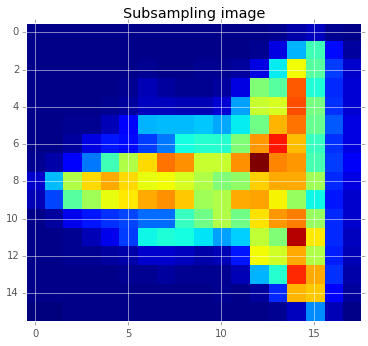

Before subsampling: (20, 2, 76, 87)
After subsampling: (20, 2, 16, 18)


In [8]:
subsampled = image_data.subsample((1, 5, 5))
# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension
plt.figure(figsize=(6,6))
plt.imshow(subsampled.first()[0], interpolation='nearest', aspect='equal')
plt.title("Subsampling image")
plt.show()
print("Before subsampling:", image_data.shape)
print("After subsampling:", subsampled.shape)

<div class="alert alert-warning">  
We can see that the resulting image has a definition way lower than the original one, and this is confirmed by the shape of the image before and after the subsampling: obviously the number of images (20) and the number of layers (2) did not change, while the difference in the number of pixels is huge. We moved from $6612$ (given by $76\cdot87$) to $288$ (given by $16\cdot18$) and this had big impacts on the image, that is probably unusable with such a bad definition.
</div>

Note that `subsample` is an RDD operation, so it returns immediately. Indeed, we know that in Spark you must apply a RDD action to trigger the actual computation.

### d. Converting image data
We can also convert an RDD of images to a RDD of series by:

In [9]:
seriesRDD = image_data.toseries()
seriesRDD.cache()

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">
According to your understanding about `Series` objects which was introduced in section 1, what is the shape of `seriesRDD` and its elments ?  

Comment your results, don't just display numbers.
</div>

In [10]:
print(seriesRDD.shape)

(2, 76, 87, 20)


<div class="alert alert-warning">
In Thunder an `image` is a set of images (one for each layer) to represent a 3D object. The `series` data type,  on the other hand, is used to represent a collection of one-dimensional records that share a common index and it is mainly used to represent temporal dependencies.
<br>
In this way we can understand the change in the order on indexes (the only change that there has been between `image` and `series`): in the series when we get an element we get the evolution of that element over the 20 images of our dataset. For instance, if we print:
</div>

In [11]:
print(seriesRDD.first())

[26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]


<div class="alert alert-warning">
we get the evolution of the first pixel over the 20 images.
<br><br>It is different in the case of `image`, indeed if we print:
</div>

In [12]:
print(image_data.first())

[[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


<div class="alert alert-warning">
we get the two layers of the first image.
</div>

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a `Series`, rather than repeatedly converting the images to a `Series` object. This can be performed either through a ThunderContext method, `convertImagesToSeries`, or directly on an Images object, as done below:

In [13]:
# image_data.toseries().tobinary('image-data', overwrite=True)
#ts = td.series.frombinary('image-data', engine=sc)

We will study about `Series` object in the next section.

## 2.2. Play with Serises objects

### a. Loading Series data

In this section, we use a sample data to explore `Series` objects.

In [14]:
# series_data = td.series.fromexample('fish', engine=sc)
# series_data = td.series.frombinary(path='s3n://thunder-sample-data/series/fish', engine=sc)
series_data = image_data.toseries()

### b. Inspecting Series data

`Series_data` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single `voxel`. We can look at the first record by using `first()`. It’s a key-value pair, where the key is a tuple of `int` (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array.

In [15]:
first_series = series_data.first() # get the values of Series object
#first_series = series_data[0] # get a Series object

print("Shape of series:", series_data.shape)
print("The first series:", first_series)
print("Each element in series has", len(first_series), "values")

# print the 10th value of voxel (0,0,0)
# layer = 0
# coordinator = (0,0) in that layer
print("value 10th of voxel (0, 0, 0):", np.array(series_data[0, 0, 0, 10]))

Shape of series: (2, 76, 87, 20)
The first series: [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
Each element in series has 20 values
value 10th of voxel (0, 0, 0): 25


The loaded series data is a multi-dimensional array. We can access the values of a voxel in time series by using a tuple as above. In our data, each voxel has 20 values corresponding to 20 states at 20 different times.

### c. Selecting Series data
Series objects have a 1D index, which can be used to subselect values.

In [16]:
print("shape of index:", series_data.index.shape)
print("the first element of a subset", series_data.between(0, 8).first())

shape of index: (20,)
the first element of a subset [26 26 26 26 26 26 26 25]


Values can be selected based on their index:

In [17]:
print(series_data.select(lambda x: x > 3 and x < 8).index)
print(series_data.select(lambda x: x > 3 and x < 8).first())

[4, 5, 6, 7]
[26 26 26 25]


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 5
<div class="alert alert-info">

Plot the first 20 values of **all** series objects (that is the values of a voxel) in the series data. This means, on the same plot, you should visualize the values each voxel takes in the first 20 time intervals.

</div>

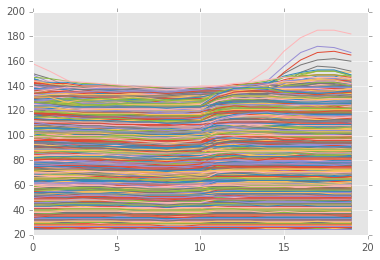

In [18]:
import numpy as np

# only select the first 20 states of each object
samples = series_data.between(0, 20).tordd().values().collect()

plt.plot(np.array(samples).T)
plt.show()

<div class="alert alert-warning">
This plot is a mess, there are too many lines plotted and it's not possible to understand anything. We tried to figure out why and we realized that the reason is the huge number of lines we are trying to plot in a single figure:
</div>

In [19]:
print("Number of lines printed:", len(np.array(samples)))

Number of lines printed: 13224


<div class="alert alert-warning">
It doesn't make sense to print such a graph, especially because we are cosidering all the points as if they had the same importance, but that's not the case since the most reasonable thing to do is to consider only the points that vary during time, we should as well ignore the noise (i.e. points with only very small variations).
</div>

Now, another objective we can have is to select specific series objects within the same series data. For example, we can select objects randomly by using function `sample`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6

<div class="alert alert-info">

Let's plot a random subset of the data using the method `sample`.  

Complete the source code below to plot the first 20 values of 30 objects that are selected randomly among those that pass the condition on the standard deviation, using function `sample`.

</div>

<div class="alert alert-warning">
We wanted to get a reasonable threshold, such that we have points that vary pretty much and are not too many.
</div>

In [20]:
thresholds = np.arange(0, 15.5, .5)
num_points = []

for i in range(len(thresholds)):
    num_points.append(series_data.filter(lambda x: x.std() >= thresholds[i]).count())
    print("for threshold", thresholds[i], "we have", num_points[i], "points to plot")

for threshold 0.0 we have 13224 points to plot
for threshold 0.5 we have 5633 points to plot
for threshold 1.0 we have 3532 points to plot
for threshold 1.5 we have 2421 points to plot
for threshold 2.0 we have 1829 points to plot
for threshold 2.5 we have 1453 points to plot
for threshold 3.0 we have 1164 points to plot
for threshold 3.5 we have 941 points to plot
for threshold 4.0 we have 783 points to plot
for threshold 4.5 we have 633 points to plot
for threshold 5.0 we have 508 points to plot
for threshold 5.5 we have 413 points to plot
for threshold 6.0 we have 346 points to plot
for threshold 6.5 we have 288 points to plot
for threshold 7.0 we have 241 points to plot
for threshold 7.5 we have 204 points to plot
for threshold 8.0 we have 165 points to plot
for threshold 8.5 we have 135 points to plot
for threshold 9.0 we have 104 points to plot
for threshold 9.5 we have 77 points to plot
for threshold 10.0 we have 48 points to plot
for threshold 10.5 we have 34 points to plot
for

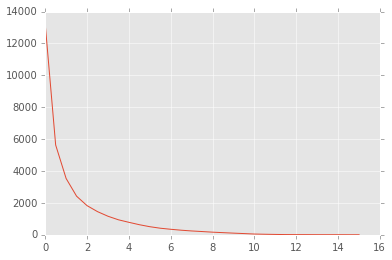

In [21]:
plt.plot(thresholds,num_points)
plt.show()

<div class="alert alert-warning">
We can see from the plot that the behaviour looks hyperbolic: a huge amount of points have standard deviation equal to 0, and few points has a huge stddev.<br>We decided to consider as threshold 10.0, in this question.
</div>

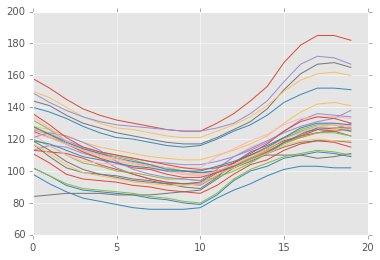

In [22]:
# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
examples = series_data.filter(lambda x: x.std() >= 10.0).sample(30)
# only plot first 20 states of each object
plt.plot(np.array(examples).T)
plt.show()

<div class="alert alert-warning">
In this graph we start seeing something more interesting, since most of the points have a similar behaviour throughout the 20 images: decreasing until the 10th image and then increase again. The main difference between the different lines is that they are located at different positions on the y-axis.
</div>

### d. Preprocessing Series data
A `Series` objects has some methods which can be useful in an eventual preprocessing phase.

For example,`center` subtracts the mean, `normalize` subtracts and divides by a baseline (either the mean, or a percentile).

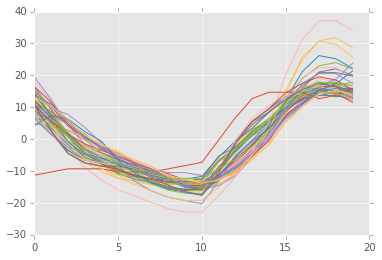

In [23]:
examples = series_data.center().filter(lambda x: x.std() >= 10).sample(50)
plt.plot(np.array(examples).T)
plt.show()

<div class="alert alert-warning">
We can see that in this case the lines are at the same "height", since we are using the `center` method.
</div>

In [24]:
normalizedRDD = series_data.normalize(method='mean').filter(lambda x: x.std() >= 0.1).sample(50)
plt.plot(np.array(normalizedRDD).T)
plt.show()

### e. Computing statistics about Series data
A `Series` can be summarized with statistics both within and across images. To summarize **across records** (the statistic of all voxels at each timestamp), we can do the following:

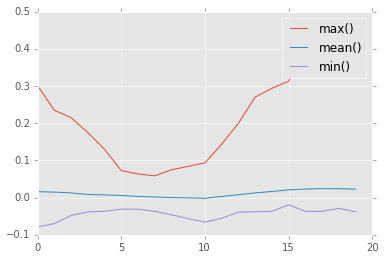

In [25]:
plt.plot(series_data.normalize().max(), label='max()')
plt.plot(series_data.normalize().mean(), label='mean()')
plt.plot(series_data.normalize().min(), label='min()')
plt.legend()
plt.show()

<div class="alert alert-warning">
It's interesting to notice how the `max` value changes a lot throughout the images, while the `min` and, even more, the `mean` are way more stable.
</div>

To summarize **within records**, we can use the `map` method:

In [26]:
means = series_data.map(lambda x: x.mean())
flat_means = means.flatten().toarray()
flat_stdevs = stdevs = series_data.map(lambda x: x.std()).flatten().toarray()
print("means:", flat_means)
print("length of means:", len(flat_means))
print("mean of the first series:", flat_means[0])
print("standard deviation of the first series:", flat_stdevs[0])

means: [ 25.8   25.85  25.7  ...,  26.    26.    26.  ]
length of means: 13224
mean of the first series: 25.8
standard deviation of the first series: 0.4


`means` is now a `Series` object, where the value of each record is the mean across the time series for that voxel.

Note that in the source code above, we use function `toarray` to return all records to the driver as a numpy array.

For this `Series`, since the keys correspond to spatial coordinates, we can `pack` the results back into a local array in **driver node**.


To look at this array as an image, we can use function `draw_image` as before.

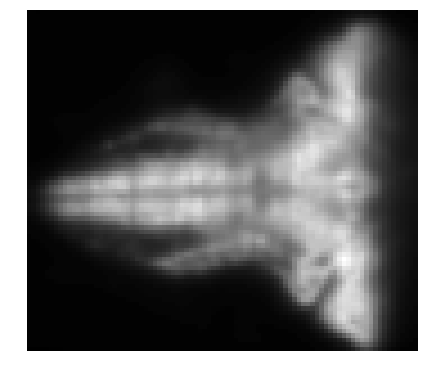

In [27]:
# we should recover the shape of means before plotting
# draw the stdandard deviations of series that belong to the first layer
draw_image(flat_means.reshape((2, 76, 87)) [0, :, :])
plt.show()

Note that `toarray` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. In this case, packing the mean is no problem because its size is quite small. But for larger data sets, this can be **very problematic**. So, it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to pack large image data sets! 

### f. Identifying correlations

In several problem domains, it may also be beneficial to assess the similarity between a designated signal (time series) and another signal of interest by measuring their correlation. For example, say we have two time series corresponding to the consumption of Coca Cola and Pepsi, it would perhaps be interesting to verify whether behavioural patterns are similar for both brands over time.<br>

Simply as a proof of concept, we shall compare our data to a random signal and we expect that, for a random signal, the correlation should be low. The signal can be stored as a numpy array or a MAT file containing the signal as a variable. Note that the size of the signal must be equal to the size of each `Series` element.

In [28]:
from numpy import random
signal = random.randn(len(first_series))
print("The correlation of the first element with random signal:" , series_data.correlate(signal).first())

first_element = series_data.first()
corr = series_data.correlate(np.array(first_element)).first()
print("The correlation of the first element with itselft:", corr)

The correlation of the first element with random signal: [ 0.25121134]
The correlation of the first element with itselft: [ 1.]


<div class="alert alert-warning">
As expected, the correlation with a random signal is very low, while the correlation with itself is equal to 1.
</div>

# 3. Usecase

## 3.1. Context
Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

In this notebook,  we use K-Means, a well known clustering algorithm which is also familiar to you, as it was introduced during the last lecture on anomaly detection.

## 3.2 Data
The dataset we will use is the time series data which we played with in the previous section. Refer to section 2 if you want to duplicate the code to load such data.

## 3.3.  Building model
### a. Importing required modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans, KMeansModel
from matplotlib.colors import ListedColormap
import thunder as td
import numpy as np
import time


plt.style.use('ggplot')

# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile

### b. Loading & inspecting the data

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Load example series data from `fish`, then normalize and cache it to speed up repeated queries. Print the dimensional information of the loaded data.

</div>

In [2]:
# we must normalize it to get best clustering
data = td.images.fromexample('fish', engine=sc).toseries().normalize()

# cache it to speed up related queries
data.cache()

# check the dimensions of data
print('Dimensions:', data.shape)

Dimensions: (2, 76, 87, 20)


<div class="alert alert-warning">
We have 20 images, each one has two layers and each layer has size 76x87.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">
When studying the properties of large data set, we often take a small fraction of it. We have many strategies to select this subset, such as selecting randomly, selecting elements that has the standard deviation bigger than a threshold, or mixing the conditions.  

In this notebook, we will use the second method as a small demonstration.

<ul></ul>

In order to choose a good value for the threshold of standard deviation, we should compute the stddev of each series and plot a histogram of a 10% sample of the values.

<ul></ul>

Complete the source code below to compute the standard deviation of series in data. Plot the histogram of it and discuss it in details. In your opinion, what should be the best value for the threshold ?

</div>

In [3]:
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram
stddevs = data.map(lambda x: x.std()).sample(int(data.count() * 0.1))

# plot the histogram of 20 bins
plt.hist(stddevs.toarray(), 20)
plt.show()

In [4]:
threshold = 0.05
data_count = data.count()
print("Percentge of data over the threshold:",data.filter(lambda x: x.std() >= threshold).count()/data_count *100,"%")

Percentge of data over the threshold: 4.620387174833636 %


<div class="alert alert-warning">
We decided to set `0.05` as threshold to keep only the points that change the most in the image.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9

<div class="alert alert-info">

Extract some samples just to look at the typical structure of the time series data.
The objects are selected randomly, and has the standard deviation bigger than the threshold which you picked in question 8.
Plot the samples and discuss your obtained figure.

</div>

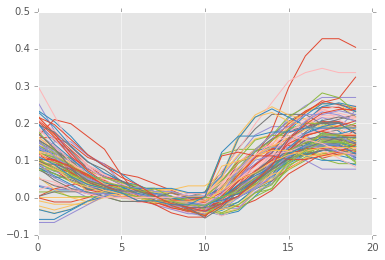

In [5]:
# sample 50 objects of the data randomly base on the standard deviation
examples = data.filter(lambda x: x.std() >= threshold).sample(100)

# plot the sample data
plt.plot(np.array(examples).T)
plt.show()

<div class="alert alert-warning">
This plot is a bit too crowded, thus we decided to sample only 20 points in order to be able to better see the evolution.
</div>

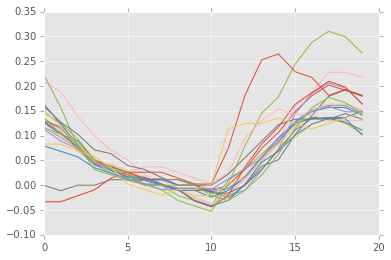

In [6]:
# sample 50 objects of the data randomly base on the standard deviation
examples = data.filter(lambda x: x.std() >= threshold).sample(20)

# plot the sample data
plt.plot(np.array(examples).T)
plt.show()

<div class="alert alert-warning">
We chose a threshold pretty high, thus we only keep points that change quite a lot throughout the 20 images, we can see that most of the points have a similar behaviour, with the lowest values for the 10th image. This is not always true, though, since we can see that, for instance, in the first image (index `0`) some of the point has a value as low as the one in the 10th image.
</div>

### c. Clustering series
In this section, we will use K-means to cluster the series. In other words, we cluster the voxels based on the their behavior. Currently, we have no clue about how many groups `K` of neural behavior. To this end, instead of choosing a single value K, we use multiple values, build model with each `K` and compare the resulting error values. After that, we can choose the best value of `K`. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Complete the source below to build multiple models coresponding to multiple values of `K` using algorithm KMeans of Thunder.  

a) Comment the structure of the code. Precisely, focus on the `for` loop, and state what is parallel and what is not.  

b) Can you modify the structure of the code such that you use the most of the parallelization capabilities of Spark?  

</div>

In [52]:
# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
training_data_bc = sc.broadcast(training_data.collect())
ks = [2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100, 200]

In [53]:
def buildModelsSpark(data, ks):
    # declare the collection of models
    models = []
        
    # build model for each K and append to models
    for k in ks:    
        models.append(KMeans.train(data, k, maxIterations=100, initializationMode="random"))
    return models

def buildModelSpark(data, k):
    return KMeans.train(data, k, maxIterations=100, initializationMode="random")

In [54]:
t0 = time.time()
models = buildModelsSpark(training_data, ks)
print('Completed in %f s' % (time.time() - t0))

Completed in 34.662158 s


In [55]:
import sklearn.cluster as skl_cluster

def buildModels(data, ks):
    # declare the collection of models
    models = []
        
    # build model for each K and append to models
    for k in ks:    
        models.append(skl_cluster.KMeans(k, max_iter=100).fit(data))
    return models

t0 = time.time()
models_sk = buildModels(training_data_bc.value, ks)
print('Completed in %f s' % (time.time() - t0))

Completed in 26.862513 s


<div class="alert alert-warning">
Below the ** parallelized ** version.
</div>

In [56]:
import time

def buildModel(data, k):
    return skl_cluster.KMeans(k, max_iter=100).fit(data)

t0 = time.time()
parallel_models = sc.parallelize(ks).map(lambda x: buildModel(training_data_bc.value, x)).collect()
print('Completed in %f s' % (time.time() - t0))

Completed in 16.103830 s


<div class="alert alert-warning">
We can see the difference in performances: the parallelized version is more efficient, even though the difference is not very big.
<br/>
We also notice that for such a small dataset the Spark KMeans version is slower than the one offered by `sklearn`, this is probably due to the fact that, since the dataset is small, it wastes a lot of time pushing the data on the Spark cluster, rather than actually calculate the centroids.
</div>

### d. Testing models & choosing the best one

Next, we evaluate the quality of each model. We use two different error metrics on each of the clusterings. 

* The first is the sum across all time series of the Euclidean distance from the time series to their cluster centroids. 

* The second is a built-in metric of the `KMeansModel` object.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11

<div class="alert alert-info">  

a) Write function `model_error_1` to calculate the sum of Squared Euclidean Distance from the Series objects to their clusters centroids.  

b) Comment the choice of the error function we use here. Is it a good error definition?

</div>

In [132]:
from scipy.spatial.distance import cdist

# calculate the Euclidean distance
# from each time series to its cluster center
# and sum all distances
def model_error_1(data, model):
    if type(data) == pyspark.rdd.PipelinedRDD:
        data = td.series.fromarray(data.collect())
    errors = data.map(lambda x: cdist([x], [model.centers[model.predict(x)]], metric='sqeuclidean'))
    return errors.sum().values[0][0]

<div class="alert alert-warning">
This is a commonly used definition for calculating error on KMeans clustering. If we only consider this type of error, we may incur into overfitting, because we may tend to prefer an higher number of clusters, containing few but very close points to the centroids.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

a) Write function `model_error_2` to calculate the total of similarity of `Series` objects based on how well they match the cluster they belong to, and then calculate the error by inverse the total similarity.  

b) Similarly to the previous question, comment the choice of the similarity function.  

</div>

In [135]:
# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(centers, p):
    if np.std(p) == 0:
        return 0
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]


def model_error_2(data, model):
    if type(data) == pyspark.rdd.PipelinedRDD:
        data = td.series.fromarray(data.collect())
    return 1. / data.map(lambda p: similarity(model.centers, p)).reduce(lambda a,b: a+b).values[0][0]

<div class="alert alert-warning">
This appears to be a more accurate and sophisticated way to calculate the accuracy of a cluster. We only consider how similar are points within each other, this way we avoid to consider clusters with an heterogeneous kind of points. Upon a certain $k$ we expect this error not to decrease much, because we should already have homogeneous points within clusters.
<br/>
Upon this consideration, we may pay attention to this error value and choose a $k$ when this error stop decreasing.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Plot the error of the models along with the different values of K in term of different error metrics above. From the figure, in your opinion, what is the best value for `K` ? Why ?

</div>

In [59]:
def testAndPlotTheResult(data, models, coefficient=None, ax=None):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1(data,model) for model in models])
    
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2(data,model) for model in models])
    
    if coefficient is not None:
        errors_3 = errors_1 + errors_2 + np.array(ks) * coefficient

    if ax is None:
        # plot the errors with each value of K
        plt.figure(figsize=(8,8))
        plt.plot(
            ks, errors_1 / errors_1.sum(), 'k-o',
            ks, errors_2 / errors_2.sum(), 'b:v'
        )
        if coefficient is not None:
            plt.plot(
                ks, errors_3 / errors_3.sum(), 'g-o'
            )
        plt.show()
    else:
        ax.plot(
            ks, errors_1 / errors_1.sum(), 'k-o',
            ks, errors_2 / errors_2.sum(), 'b:v'
        )
        if coefficient is not None:
            ax.plot(
                ks, errors_3 / errors_3.sum(), 'g-o'
            )

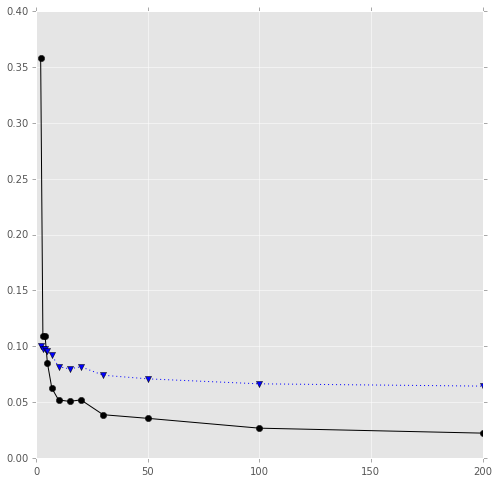

In [60]:
testAndPlotTheResult(training_data, models)

<div class="alert alert-warning">
Here we have plotted the errors depending on the number of clusters: this graph could lead us to say that it is always a better solution to have a bigger number of cluster, but this approach leads to overfitting! Thus we defined, in the function `testAndPlotTheResult`, a coefficient that we use to give a cost to each cluster. In this way we try to find the best tradeoff between lowering the error and keeping a low number of clusters.
</div>

In [61]:
# find best coefficient for MDL
coefficients = [1, 0.5, 0.3, 0.1, 0.05, 0.01]
fig, axes = plt.subplots(len(coefficients) // 2, 2, figsize=(15, len(coefficients) // 2 * 6))
for ax, coefficient in zip(axes.flat, coefficients):
    testAndPlotTheResult(training_data, models, coefficient, ax)
plt.show()

<div class="alert alert-warning">
Looking at all these plots we have a deeper insight into the behaviour depending on the number of clusters, we decided to keep `k=50` as best model.
</div>

Determining the optimal $k$ is particularly troublesome for the $k$-Means algorithm because error measures based on distance decrease monotonically as $k$ increases. This arises because when $k$ is increased, each cluster is decomposed into more and more clusters, such that each point becomes closer to its cluster mean. In fact, in the extreme case where $k=N$, each point will be assigned to its own cluster, and all distances are reduced to nil. Cross-validation or using holdout data is also unlikely to be particularly effective in this case.<br>

To this end, it is often worth assessing a model by measuring its impact on the overall aim of carrying out the clustering. For example, if we are carrying out $k$-means for grouping customers having similar taste and purchase history with the ultimate intent of making recommendations to customers, our objective function should measure how effective the recommendations are (perhaps using holdout data). An appealing aspect of using such a metric is that it is no longer guaranteed to behave monotonically with respect to $k$. We shall investigate this further in Question 20.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Plot the centroids of the best model. Do you think that the result is good ?

</div>

In [62]:
# plot the best performing model
bestModel = models[9]
plt.plot(np.asarray(bestModel.centers).T)
plt.show()

<div class="alert alert-warning">
Now we can compare this with all the other clustering.
</div>

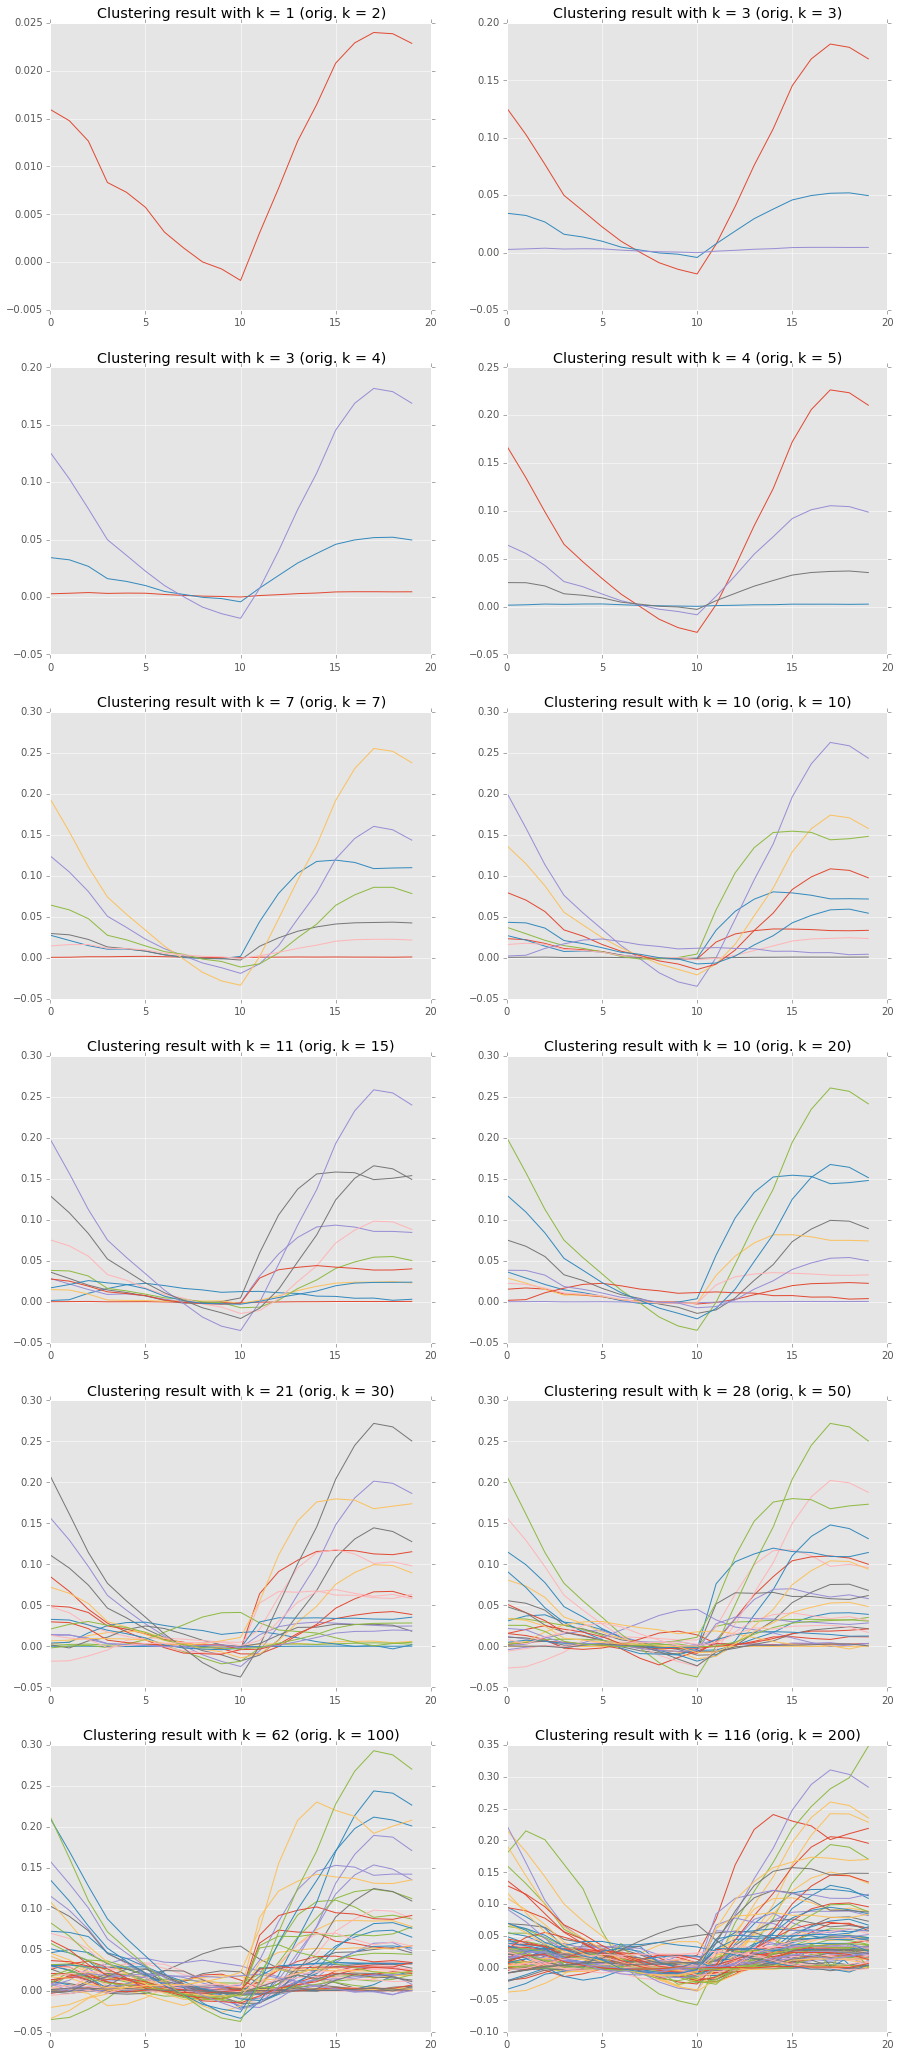

In [63]:
fig, axes = plt.subplots(len(models) // 2, 2, figsize=(15, len(models) // 2 * 6))
for ax, model, k in zip(axes.flat, models, ks):
    ax.plot(np.asarray(model.centers).T)
    ax.set_title("Clustering result with k = %d (orig. k = %d)" % (model.k, k))
plt.show()

<div class="alert alert-warning">
Looking at each clustering we also considered that when we show the clusters on a plot, if we have too many clusters we probably wouldn't be able to get any useful information from it.
</div>

### e. Visualizing the result
We can also plot an image of labels of neurons, such that we can visualize the group of each neuron.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 15

<div class="alert alert-info">

Complete the source code below to visualize the result of clustering.

</div>

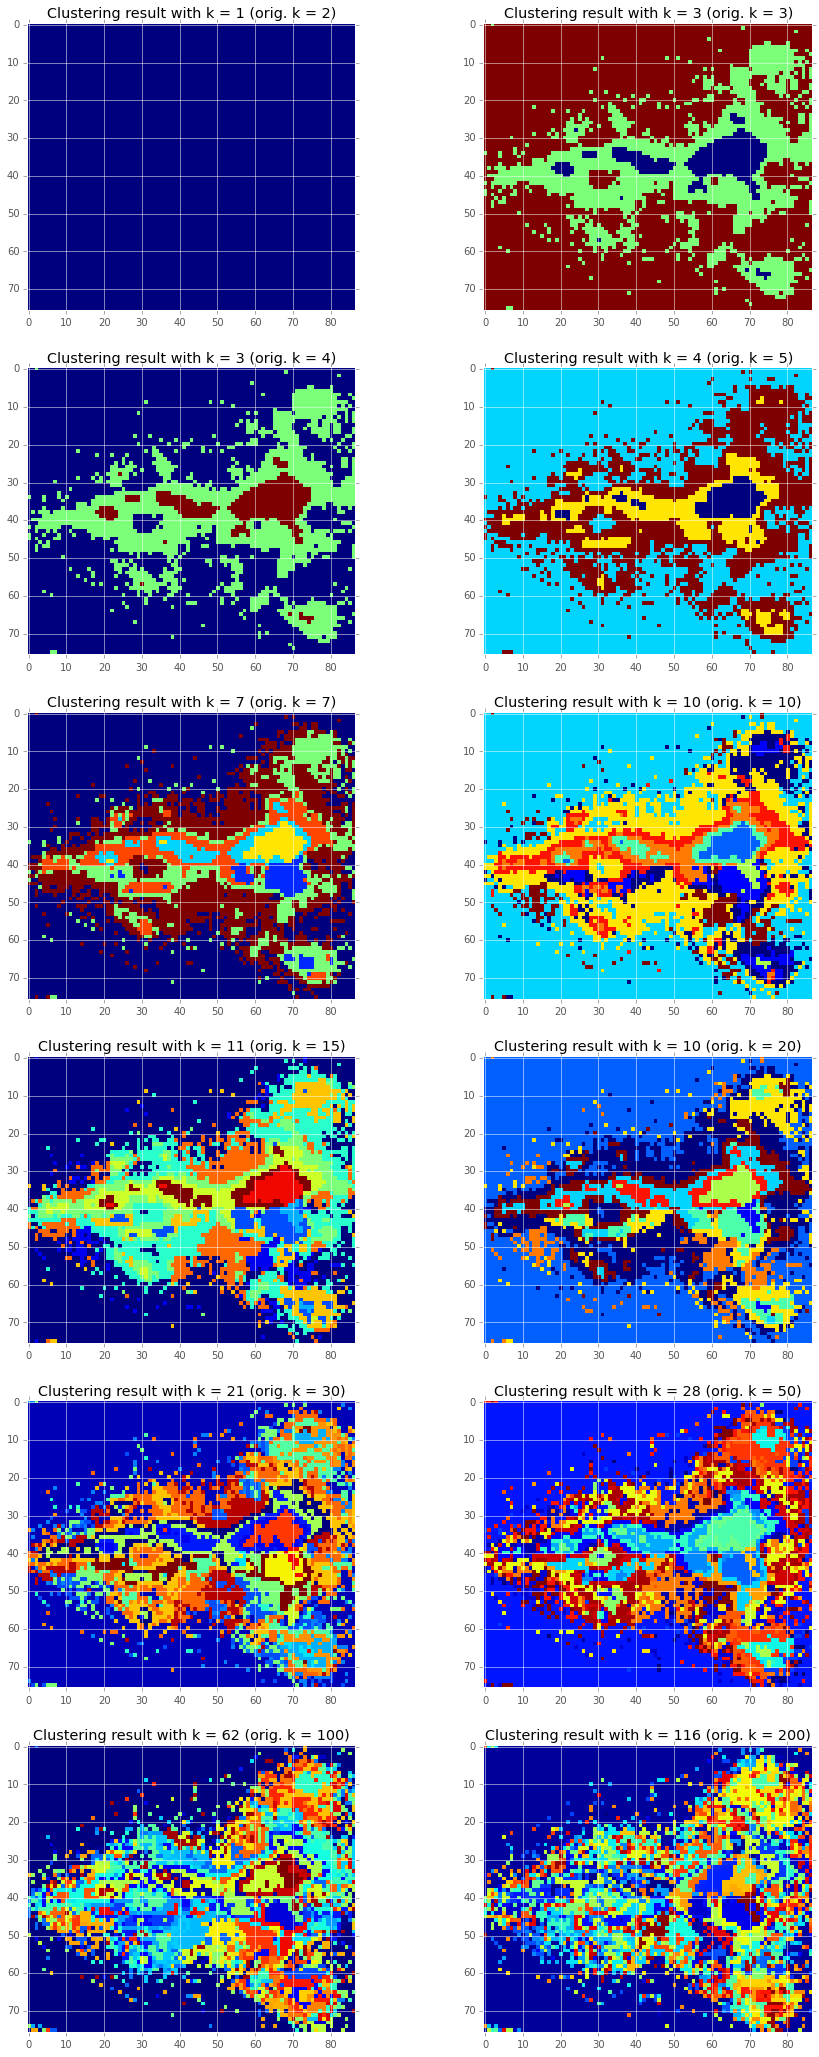

In [64]:
fig, axes = plt.subplots(len(ks) // 2 + len(ks) % 2, 2, figsize=(15, (len(ks) // 2) * 6))

data_rdd = data.tordd().map(lambda x: np.array(x[1])).cache()

for ax, model, k in zip(axes.flat, models, ks):
    # predict the nearest cluster id for each voxel in Series
    labels = model.predict(data_rdd)

    # collect data to the driver
    imgLabels = np.asarray(labels.collect()).reshape((2, 76, 87))

    # consider the voxel of the first layers
    #plt.subplot(1,2,1)
    ax.imshow(imgLabels[0,:,:], interpolation='nearest', aspect='equal')
    ax.set_title("Clustering result with k = %d (orig. k = %d)" % (model.k, k))
plt.show()

<div class="alert alert-warning">
We can see here the problem we were talking about before, when we have too many clusters we cannot understand anything from the plots, the point is to find the best tradeoff.
<br>
In the next cell we are going to show both the plots close to each other, to make more visible the possible relations between them.
</div>

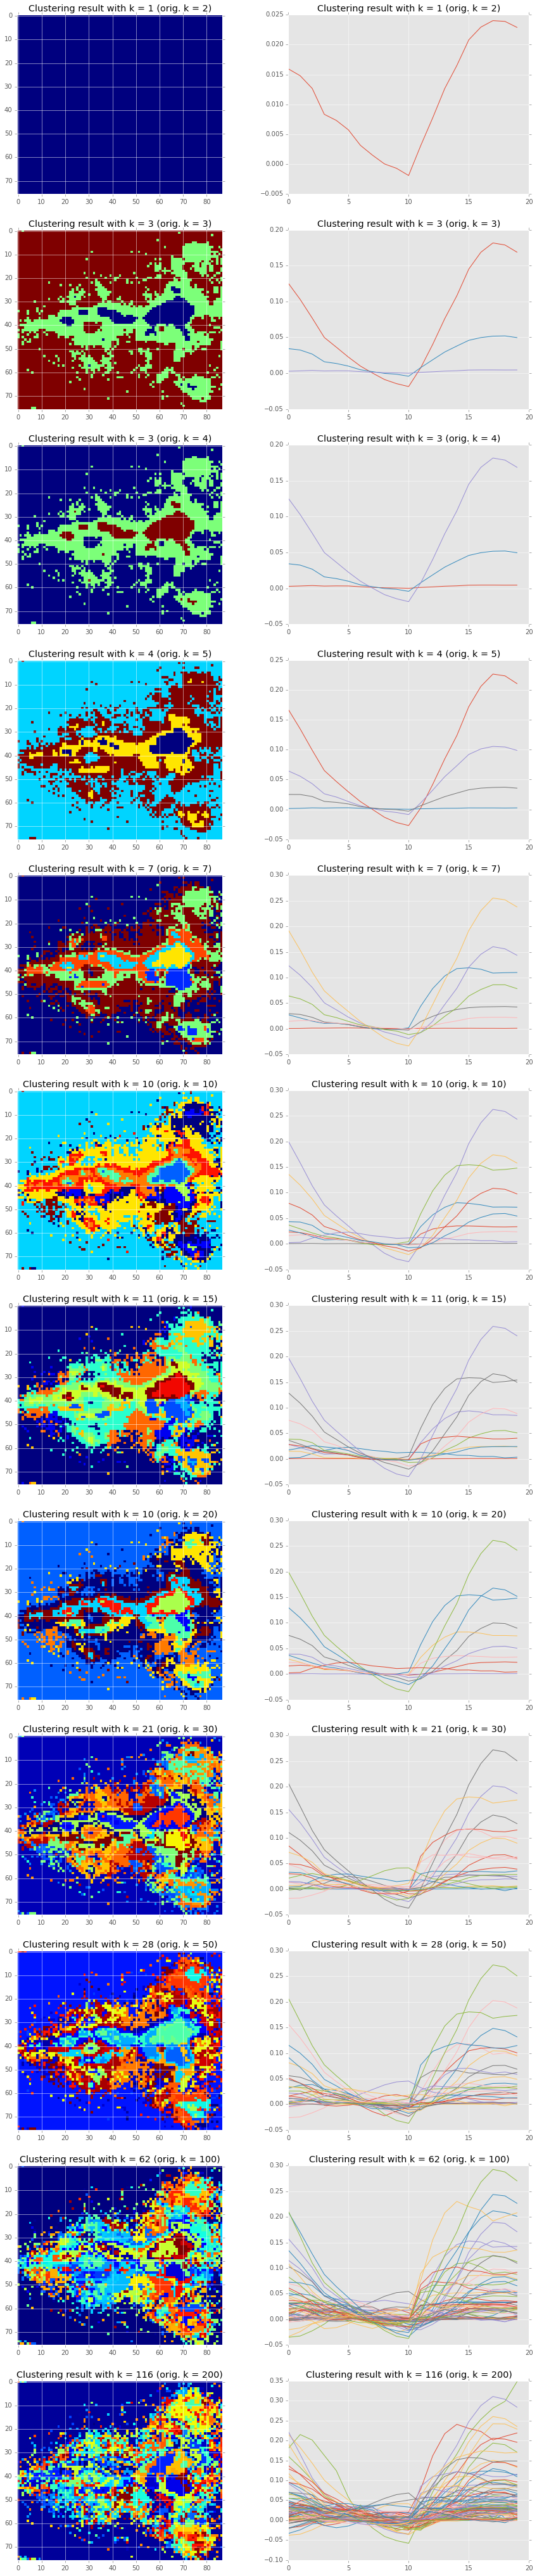

In [65]:
fig, axes = plt.subplots(len(ks), 2, figsize=(15, len(ks) * 6))

data_rdd = data.tordd().map(lambda x: np.array(x[1])).cache()

for (ax1, ax2), model, k in zip(axes, models, ks):
    # predict the nearest cluster id for each voxel in Series
    labels = model.predict(data_rdd)

    # collect data to the driver
    imgLabels = np.asarray(labels.collect()).reshape((2, 76, 87))

    # consider the voxel of the first layers
    #plt.subplot(1,2,1)
    ax1.imshow(imgLabels[0,:,:], interpolation='nearest', aspect='equal')
    ax1.set_title("Clustering result with k = %d (orig. k = %d)" % (model.k, k))
    ax2.plot(np.asarray(model.centers).T)
    ax2.set_title("Clustering result with k = %d (orig. k = %d)" % (model.k, k))
plt.show()

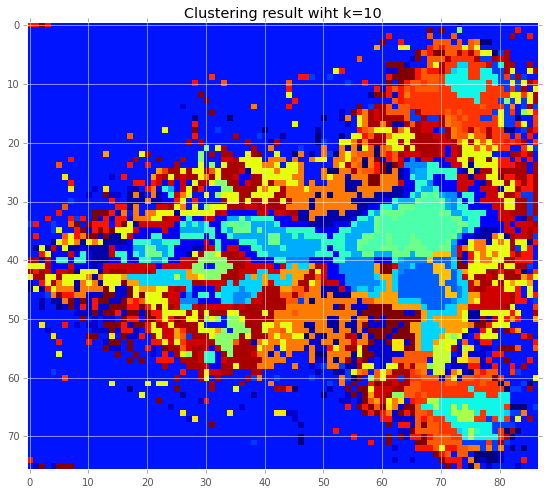

In [66]:
# predict the nearest cluster id for each voxel in Series
labels = bestModel.predict(training_data)

# collect data to the driver
imgLabels = np.asarray(labels.collect()).reshape((2, 76, 87))

# consider the voxel of the first layers
plt.figure(figsize=(15,8))
#plt.subplot(1,2,1)
plt.imshow(imgLabels[0,:,:], interpolation='nearest', aspect='equal')
plt.title("Clustering result wiht k="+str(ks[5]))
plt.show()

With the default color scheme, this figure is quite difficult to understand and to distinguish the groups according to their similar colors. So, we should have a smater color selection. The fact is, when we do clustering, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The method `optimize` tries to find a set of colors such that similaries among colors match similarities among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

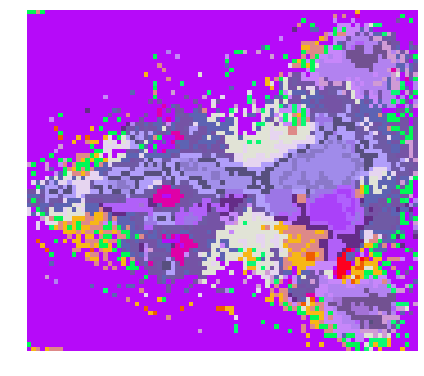

In [67]:
from numpy import arctan2, sqrt, pi, abs, dstack, clip, transpose, inf, \
    random, zeros, ones, asarray, corrcoef, allclose, maximum, add, multiply, \
    nan_to_num, copy, ndarray, around, ceil, rollaxis

# these functions below are inspired mainly from Thunder-Project source code, v.0.6
# url: https://raw.githubusercontent.com/thunder-project/thunder/branch-0.6/thunder/viz/colorize.py

# Optimal colors based on array data similarity.
def optimize_color(mat):
        mat = np.asarray(mat)

        if mat.ndim < 2:
            raise Exception('Input array must be two-dimensional')

        nclrs = mat.shape[0]

        from scipy.spatial.distance import pdist, squareform
        from scipy.optimize import minimize

        distMat = squareform(pdist(mat, metric='cosine')).flatten()

        optFunc = lambda x: 1 - np.corrcoef(distMat, squareform(pdist(x.reshape(nclrs, 3), 'cosine')).flatten())[0, 1]
        init = random.rand(nclrs*3)
        bounds = [(0, 1) for _ in range(0, nclrs * 3)]
        res = minimize(optFunc, init, bounds=bounds, method='L-BFGS-B')
        newClrs = res.x.reshape(nclrs, 3).tolist()

        from matplotlib.colors import ListedColormap

        newClrs = ListedColormap(newClrs, name='from_list')

        return newClrs

# Blend two images together using the specified operator.
def blend(img, mask, op=add):
        if mask.ndim == 3:
            for i in range(0, 3):
                img[:, :, :, i] = op(img[:, :, :, i], mask)
        else:
            for i in range(0, 3):
                img[:, :, i] = op(img[:, :, i], mask)
        return img

def _prepareMask(mask):
        mask = asarray(mask)
        mask = clip(mask, 0, inf)

        return mask / mask.max()
    
# Colorize numerical image data.
def transform(cmap, img, mask=None, mixing=1.0):
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap, LinearSegmentedColormap, hsv_to_rgb, Normalize

        img = asarray(img)
        dims = img.shape

        if cmap not in ['polar', 'angle']:

            if cmap in ['rgb', 'hv', 'hsv', 'indexed']:
                img = copy(img)
                for i, im in enumerate(img):
                    norm = Normalize(vmin=None, vmax=None, clip=True)
                    img[i] = norm(im)

            if isinstance(cmap, ListedColormap) or isinstance(cmap, str):
                norm = Normalize(vmin=None, vmax=None, clip=True)
                img = norm(copy(img))

        if mask is not None:
            mask = _prepareMask(mask)

        if isinstance(cmap, ListedColormap):
            if img.ndim == 3:
                out = cmap(img)
                out = out[:, :, :, 0:3]
            if img.ndim == 2:
                out = cmap(img)
                out = out[:, :, 0:3]
        else:
            raise Exception('Colorization method not understood')

        out = clip(out, 0, 1)

        if mask is not None:
            out = blend(out, mask, multiply)

        return clip(out, 0, 1)


# generate the better color scheme
newClrs = optimize_color(bestModel.centers)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(bestModel.centers).T);

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap)

plt.show()

### f. Improving the result by removing noise
One problem with what we've done so far is that clustering was performed on all time-series without data pre-processing. Many of  time-series objects were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 16

<div class="alert alert-info">

Try with different threshold of standard deviation to filter the noise. What is the "best value" that preserves most of the relavant signal, but ignores the noise ? Why ?

</div>

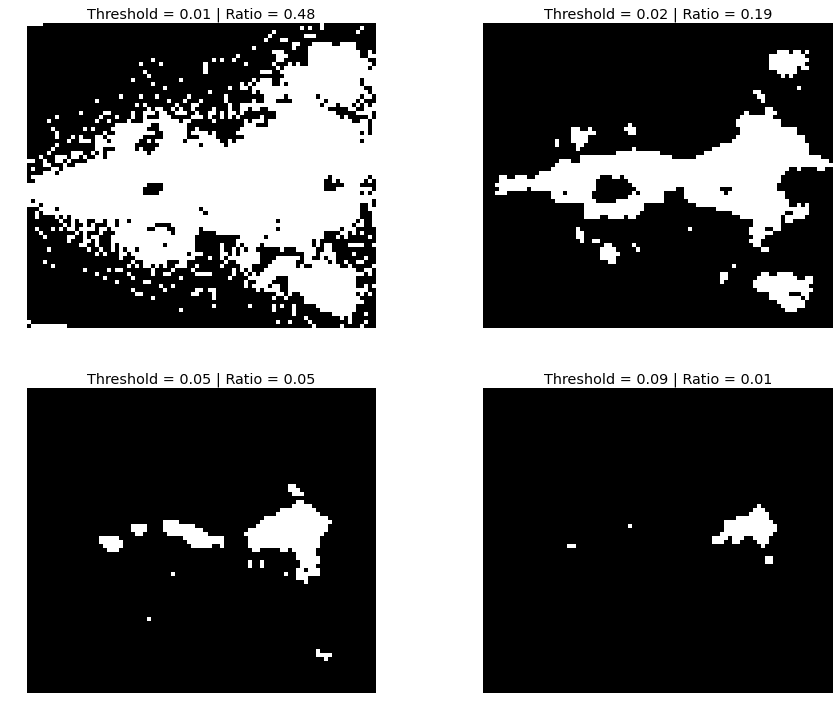

In [68]:
thresholds = [0.01, 0.02, 0.05, 0.09]

# calculate the standard deviation of each voxel 
# then collect to the driver
stdMap = data.map(lambda x: x.std()).toarray()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
data_count = data.count()

# here we should try with many different values of threshold 
# and choosing the best one
# visualize the map of the standard deviation after filtering
for ax, thres in zip(axes.flat, thresholds):
    f = stdMap[0,:,:] >= thres
    ax.set_title('Threshold = %.2f | Ratio = %.2f' % (thres, f.sum() / f.size))
    ax.set_axis_off()
    draw_image(f, ax=ax)
    
plt.show()

<div class="alert alert-warning">
In our opinion the best value for the threshold is 0.02, since we remove (almost) all the noise and we still have most of the information contained into the image.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 17

<div class="alert alert-info">

Filter your data such that we only keep the voxels that have the standard deviation bigger than the threshold in question 16.

</div>

In [23]:
from numpy import std

chosen_threshold = thresholds[1] 
print('Chosen Threshold %.2f' % chosen_threshold)

# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(lambda x: x.std() >= chosen_threshold).cache()
print('Filtered shape', filtered.shape)
print('Filtered ratio %.2f' % (filtered.count() / data.count()))

Chosen Threshold 0.02
Filtered shape (2299, 20)
Filtered ratio 0.17


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 18

<div class="alert alert-info">

Re-train and choose the best models with different values of `K` on the new data.

</div>

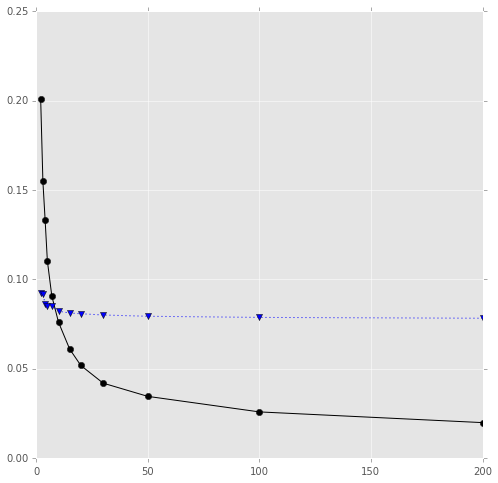

In [24]:
filtered_training_data = filtered.tordd().map(lambda x: np.array(x[1])).cache()
models = buildModelsSpark(filtered_training_data, ks=ks)
testAndPlotTheResult(filtered_training_data, models)

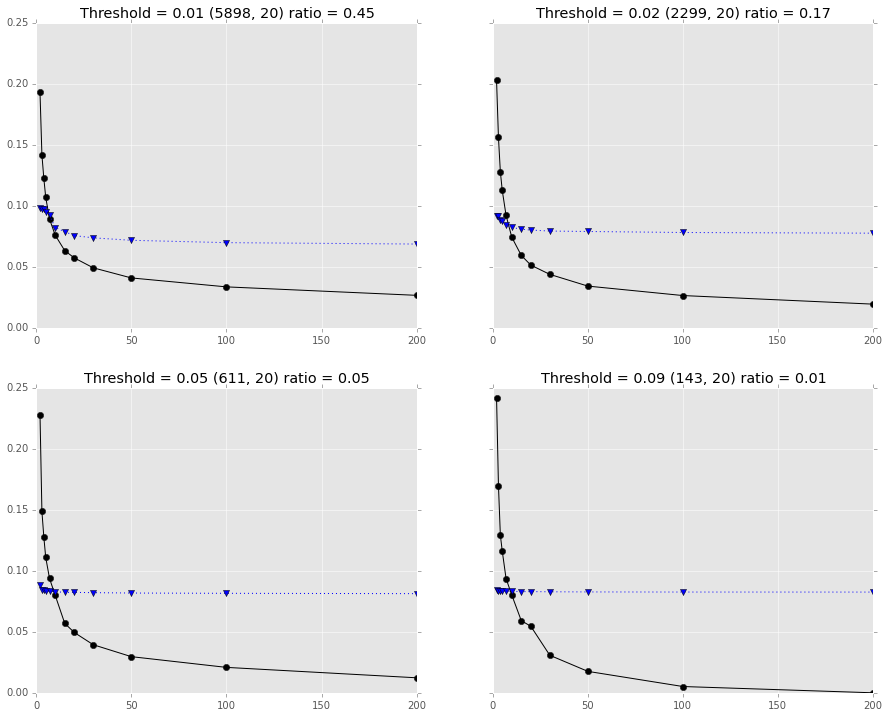

In [25]:
models = {}
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
data_count = data.count()

for ax, chosen_threshold in zip(axes.flat, thresholds):
    # remove series object that has the standard deviation bigger than a threshold
    filtered = data.filter(lambda x: x.std() >= chosen_threshold).cache()
    filtered_training_data = filtered.tordd().map(lambda x: np.array(x[1])).cache()
    
    models[chosen_threshold] = buildModelsSpark(filtered_training_data, ks)
    
    ax.set_title(('Threshold = %.2f %s ratio = %.2f' % (chosen_threshold, str(filtered.shape),
                                                        filtered.count() / data_count)))
    testAndPlotTheResult(filtered_training_data, models[chosen_threshold], ax=ax)
    
plt.show()

<div class="alert alert-warning">
Looking at this plots we can see the behaviour for different ks, and we also decided to analyze the differences depending on the threshold.
In the end, we decided to keep `k=10` as best clustering because, even though the error is not the smallest, in this way it will be possible to observe the differences between the clusters into the plot, and the similarity inside a cluster decreases very slowly for k greater than 10.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 19
<div class="alert alert-info">

a) Plot the centroids of the best model with a smart color selection.  

b) Plot the result of the clustering algorithm by a color map of voxels.  

c) Comment about your figures.  
</div>

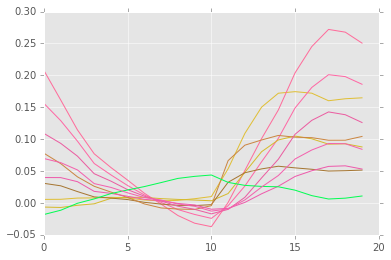

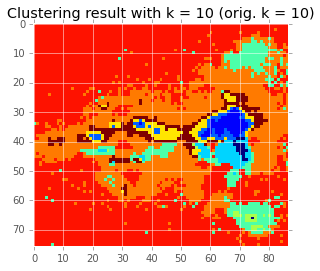

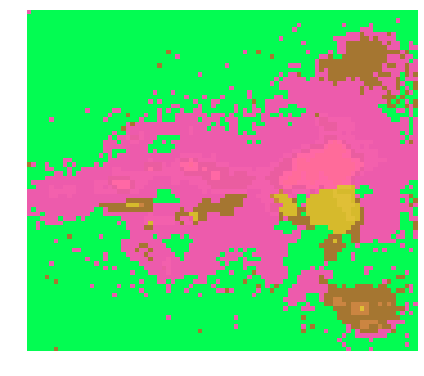

In [26]:
chosen_threshold = thresholds[1] # 0.02
chosen_k = 10
best_model = models[chosen_threshold][ks.index(chosen_k)]

# generate the better color scheme
newClrs = optimize_color(best_model.centers)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(best_model.centers).T);

plt.show()

# predict the nearest cluster id for each voxel in Series
labels = data.map(lambda x: best_model.predict(x))

# # collect data to the driver
imgLabels = labels.toarray()
#plt.subplot(1,2,1)
plt.imshow(imgLabels[0,:,:], interpolation='nearest', aspect='equal')
plt.title("Clustering result with k = %d (orig. k = %d)" % (best_model.k, chosen_k))

brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap)

plt.show()

<div class="alert alert-warning">
Choosing this number of clusters, we can observe the points with similar characteristics, when we tried to increase k, we got too many clusters and it was not possible to get any relevant information.
</div>

### g. Improve the visualization by adding similarity
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A useful trick is masking pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

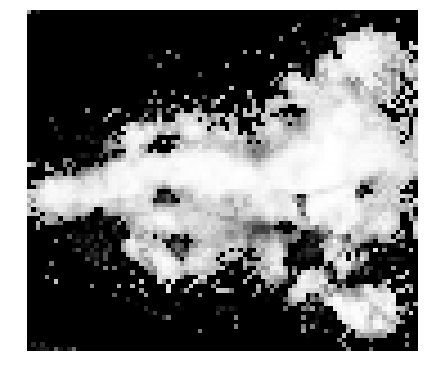

In [27]:
sim = data.map(lambda x: similarity(best_model.centers, x))

imgSim = sim.toarray()

# draw the mask
draw_image(imgSim[0,:,:], cmap='gray', clim=(0,1))

And, it can be used as a linear mask on the colorization output

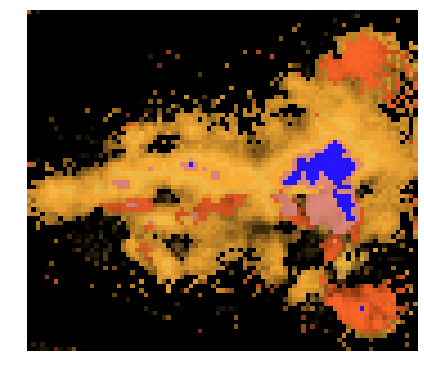

In [36]:
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
draw_image(brainmap)

<div class="alert alert-warning">
Now it easier to spot the point we are interested in, since all the background is black instead of coloured.
<div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 20

<div class="alert alert-info">

Since in the usecase we build and test the model from the same data, it can lead to overfitting problems. To avoid that, we can divide the data into training set and testing set. Note that each neuron occurs only one time in the data. So, we can not divide the data by dividing the neurons. Instead, we can divide the states of neurons into two different sets. Let's try with this approach and show the result.

</div>

In [29]:
images = td.images.fromexample('fish', engine=sc)

threshold = 0.02

volex_num = images[0].toseries().count()
test_set_size = int(0.1*volex_num)
samples_index = sc.parallelize(13223 * np.random.random_sample(test_set_size))
image_series = images.toseries().normalize()
image_series_filtered = image_series.filter(lambda x: x.std() > threshold).cache()

In [30]:
cv_models = []
training_labels = []
splits = []

for i in range(10):
    [test_set, training_set] = image_series_filtered.tordd().map(lambda x: np.array(x[1])).randomSplit([0.1, 0.9], 42)
    splits.append((test_set, training_set))
    training_set = training_set.cache()
    test_set = test_set.cache()
    cv_models.append(buildModelSpark(training_data, chosen_k))

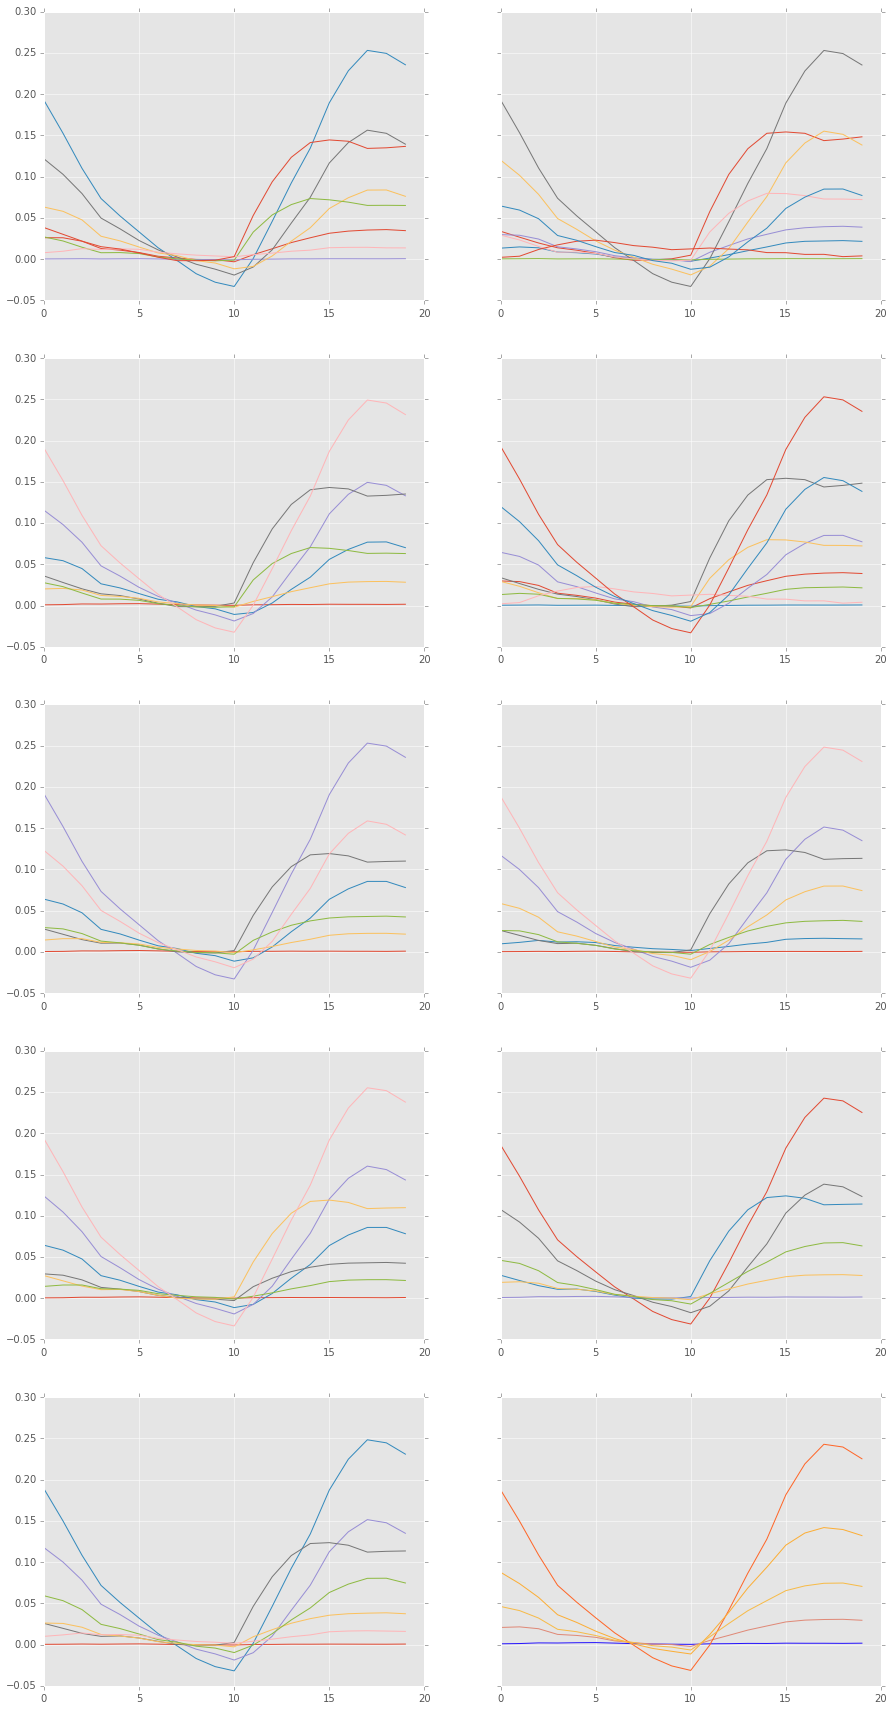

In [31]:
fig, axes = plt.subplots(5, 2, figsize=(15, 5 * 6), sharey=True)
for ax, model in zip(axes.flat, cv_models):
    newClrs = optimize_color(model.centers)
    plt.gca().set_color_cycle(newClrs.colors)
    ax.plot(np.array(model.centers).T)

    training_labels.append(model.predict(training_set).collect())
plt.show()

<div class='alert alert-warning'>
It is interesting to notice how the number of k that we set at the beginning of the training does not force the final number of cluster because, when an empty cluster is generated after an update operation, it is just removed instead of being replaced by a new randomly generated centroid. This has an effect on the errors as well, as we will see in the next cell.
<br>
We should also highlight that the removal of a cluster is not always a bad event, since it could avoid the case when we have two different clusters whose centroid are very close to each other.
</div>

In [34]:
errors = []
for model, (test_set, _) in zip(cv_models, splits):
    e1, e2 = model_error_1(test_set, model), model_error_2(test_set, model)
    errors.append([e1, e2])
    print('Errors: %f %f' % (e1, e2))
print("Average error:", np.mean(errors, axis=0))

Errors: 1.808233 0.005168
Errors: 1.762983 0.005141
Errors: 1.837992 0.005139
Errors: 1.763167 0.005140
Errors: 1.932107 0.005246
Errors: 1.985193 0.005313
Errors: 1.929490 0.005246
Errors: 2.008741 0.005340
Errors: 1.982324 0.005305
Errors: 2.446636 0.005461
Average error: [ 1.94568666  0.00525007]


<div class='alert alert-warning'>
After having run the our model with 10 different random splits, we can compute the average errors: considering `error_1` (i.e. the distance from the centroids) we noticed that there are quite big differences between differerent splits (the min is around 72% of the max), and this could lead us to think that the model is not stable (and that we are having overfitting). Anyway, if we look at `error_2` we can see that the minimum error is around 94% of the maximum one, meaning that the model is pretty stable.
<br>
It is interesting to notice that, reasonably, we have the biggest errors (both of them) in the cases with the lowest number of clusters. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 21

<div class="alert alert-info">

Is using K-Means the best choice for a clustering algorithm? Comment the choice and suggest alternatives. For example, look at [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model) and, if you have time, propose an alternative clustering technique. 

</div>

<div class="label label-danger">NOTE</div> Mixture models will be covered in the ASI course in greater detail.

In [46]:
from pyspark.mllib.clustering import GaussianMixtureModel, GaussianMixture

k_val = ks[3]

GMmodel = GaussianMixture.train(filtered_training_data, k_val, convergenceTol=0.0001, maxIterations=50, seed=10)
GMlabels = GMmodel.predict(filtered_training_data)



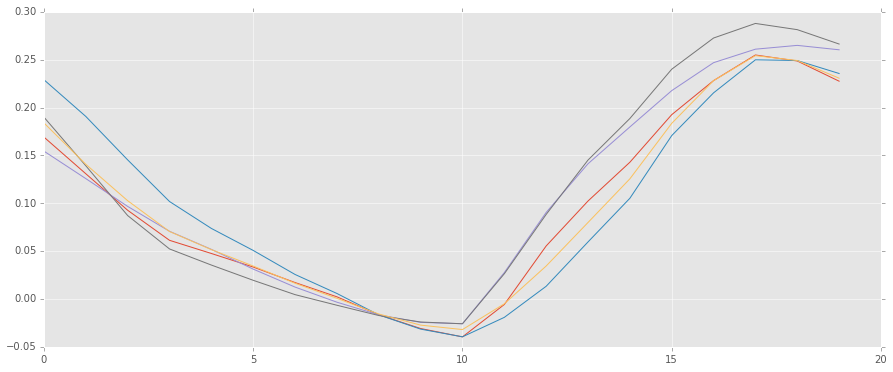

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))
for gaussian in GMmodel.gaussians:
    ax.plot(gaussian.mu)
plt.show()

<div class='alert alert-warning'>
Now we have to slightly modify the error functions in order to be able to use them with the mixture models.
</div>

In [173]:
def model_error_2(data, model):
    if type(data) == pyspark.rdd.PipelinedRDD:
        data = td.series.fromarray(data.collect())
    if type(model) == pyspark.mllib.clustering.GaussianMixtureModel:
        return 1. / data.map(lambda p: similarity([g.mu for g in model.gaussians], p)).reduce(lambda a,b: a+b).values[0][0]
    return 1. / data.map(lambda p: similarity(model.centers, p)).reduce(lambda a,b: a+b).values[0][0]
def model_error_1(data, model):
    if type(data) == pyspark.rdd.PipelinedRDD:
        data = td.series.fromarray(data.collect())
    if type(model) == pyspark.mllib.clustering.GaussianMixtureModel:
        errors = data.map(lambda x: cdist([x], [model.gaussians[model.predict(x)].mu], metric='sqeuclidean'))
    else:
        errors = data.map(lambda x: cdist([x], [model.centers[model.predict(x)]], metric='sqeuclidean'))
    return errors.sum().values[0][0]

In [175]:
for chosen_k in ks:
    cv_models = []
    training_labels = []
    splits = []

    gmm_cv_models = []
    gmm_training_labels = []

    for i in range(10):
        [test_set, training_set] = image_series_filtered.tordd().map(lambda x: np.array(x[1])).randomSplit([0.1, 0.9], 42)
        splits.append((test_set, training_set))
        training_set = training_set.cache()
        test_set = test_set.cache()
        cv_models.append(buildModelSpark(training_data, chosen_k))
        gmm_cv_models.append(GaussianMixture.train(training_data, chosen_k, convergenceTol=0.0001, maxIterations=50, seed=10))


    errors = []
    for model, (test_set, _) in zip(cv_models, splits):
        #testAndPlotTheResult(test_set, model, ax=ax)
        e1, e2 = model_error_1(test_set, model), model_error_2(test_set, model)
        errors.append([e1, e2])
        print('KMeans errors with k=%d: %f %f' % (chosen_k, e1, e2))
    np.mean(errors, axis=0)

    errors = []
    for model, (test_set, _) in zip(gmm_cv_models, splits):
        #testAndPlotTheResult(test_set, model, ax=ax)
        e1, e2 = model_error_1(test_set, model), model_error_2(test_set, model)
        errors.append([e1, e2])
        print('GMM errors with k=%d: %f %f' % (chosen_k, e1, e2))
    np.mean(errors, axis=0)

KMeans errors with k=2: 5.091176 0.005511
KMeans errors with k=2: 12.597079 0.005502
KMeans errors with k=2: 5.091176 0.005511
KMeans errors with k=2: 5.091176 0.005511
KMeans errors with k=2: 12.597079 0.005502
KMeans errors with k=2: 5.091176 0.005511
KMeans errors with k=2: 5.091772 0.005511
KMeans errors with k=2: 12.597079 0.005502
KMeans errors with k=2: 5.091176 0.005511
KMeans errors with k=2: 5.091176 0.005511
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
GMM errors with k=2: 9.591181 0.005476
KMeans errors with k=3: 3.638130 0.005467
KMeans errors with k=3: 5.091176 0.005511
KMeans errors with k=3: 3.638130 0.005467
KMeans errors with k=3: 5.091176 0.005511
KMeans errors with 

Py4JJavaError: An error occurred while calling o42005.trainGaussianMixtureModel.
: breeze.linalg.NotConvergedException: 
	at breeze.linalg.eigSym$.breeze$linalg$eigSym$$doEigSym(eig.scala:144)
	at breeze.linalg.eigSym$EigSym_DM_Impl$.apply(eig.scala:96)
	at breeze.linalg.eigSym$EigSym_DM_Impl$.apply(eig.scala:94)
	at breeze.generic.UFunc$class.apply(UFunc.scala:48)
	at breeze.linalg.eigSym$.apply(eig.scala:91)
	at org.apache.spark.mllib.stat.distribution.MultivariateGaussian.calculateCovarianceConstants(MultivariateGaussian.scala:122)
	at org.apache.spark.mllib.stat.distribution.MultivariateGaussian.<init>(MultivariateGaussian.scala:63)
	at org.apache.spark.mllib.stat.distribution.MultivariateGaussian.<init>(MultivariateGaussian.scala:55)
	at org.apache.spark.mllib.clustering.GaussianMixture.org$apache$spark$mllib$clustering$GaussianMixture$$updateWeightsAndGaussians(GaussianMixture.scala:251)
	at org.apache.spark.mllib.clustering.GaussianMixture.run(GaussianMixture.scala:220)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainGaussianMixtureModel(PythonMLLibAPI.scala:412)
	at sun.reflect.GeneratedMethodAccessor54.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


<div class='alert alert-warning'>
Comparing the two approaches, we can see that the results obtained with the Gaussian Mixture Model have worst performances and these don't change with different splits. Moreover, we unfortunately got an error due to the non-convergence.
</div>

### Another approach: Bisecting K-means
<div class='alert alert-warning'>
Bisecting K-means can often be much faster than regular K-means, but it will generally produce a different clustering.
<br>
Bisecting k-means is a kind of hierarchical clustering. Hierarchical clustering is one of the most commonly used method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:
<br>
<ul>
<li>
Agglomerative: This is a “bottom up” approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
</li>
<li>Divisive: This is a “top down” approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.
</li>
</ul>
Bisecting k-means algorithm is a kind of divisive algorithms.

</div>

In [43]:
from pyspark.mllib.clustering import BisectingKMeans

def bisectingBuildModelSpark(data,k):
    return BisectingKMeans.train(data, k, maxIterations=20, seed=np.random.randint(0,1000))

In [70]:
[test_set, training_set] = image_series_filtered.tordd().map(lambda x: np.array(x[1])).randomSplit([0.1, 0.9], 42)
splits = (test_set, training_set)
training_set = training_set.cache()
test_set = test_set.cache()
bisecting_cv_model = bisectingBuildModelSpark(training_data, chosen_k)

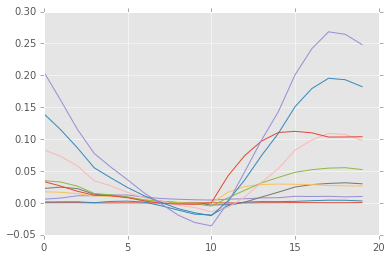

In [73]:
plt.plot(np.array(bisecting_cv_model.centers).T)
plt.show()

In [136]:
e1, e2 = model_error_1(test_set, bisecting_cv_model), model_error_2(test_set, bisecting_cv_model)
print('Errors: %f %f' % (e1, e2))

Errors: 1.920540 0.005177


<div class='alert alert-warning'>
We tried this differenct approach and the results are not bad, compared to the "standard" K-means: both the errors are comparable to the errors obtained while running the KMeans, we should run it several times to check the stability but, unfortunately, we did not have enough time to do that. 
</div>

# 4. Summary
We studied Thunder and its important methods to work with images, such as `Image`, `Series` and how to apply them to a use case. In the use case, we used the K-Means algorithm to cluster the neurons without prior knowledge of what a good choice of K could be. Subsequently, we introduced some techniques for improving the initially obtained results, such as removing noise and considering similarity.

# References
Some of the examples in this notebook are inspired from the [documentation of Thunder](http://docs.thunder-project.org/).